In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import pprint
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
from execution import *
from plot_configs import plot_configs
import json
import models

model is {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128, 'f': 102400}
training on 488281250.0 samples
TP values swept =   [8 8 8 8 8 8 8 8]
DP values swept =   [2048 1024  512  256  128   64   32   16]
PP values swept =   [  1   2   4   8  16  32  64 128]
Total GPUs used =   [16384 16384 16384 16384 16384 16384 16384 16384]
-------------------------
Config: tp = 8, dp = 2048, pp = 1
TP in NVLINK:  1
DP in NVLINK:  8
PP in NVLINK:  1
-------------------------
Config: tp = 8, dp = 1024, pp = 2
TP in NVLINK:  2
DP in NVLINK:  4
PP in NVLINK:  1
-------------------------
Config: tp = 8, dp = 512, pp = 4
TP in NVLINK:  4
DP in NVLINK:  2
PP in NVLINK:  1
-------------------------
Config: tp = 8, dp = 256, pp = 8
TP in NVLINK:  8
DP in NVLINK:  1
PP in NVLINK:  1
-------------------------
Config: tp = 8, dp = 128, pp = 16
TP in NVLINK:  8
DP in NVLINK:  1
PP in NVLINK:  1
-------------------------
Config: tp = 8, dp = 64, pp = 32
TP in NVLINK:  8
DP in NVLINK:  1
PP in NVLINK:  1
-----------

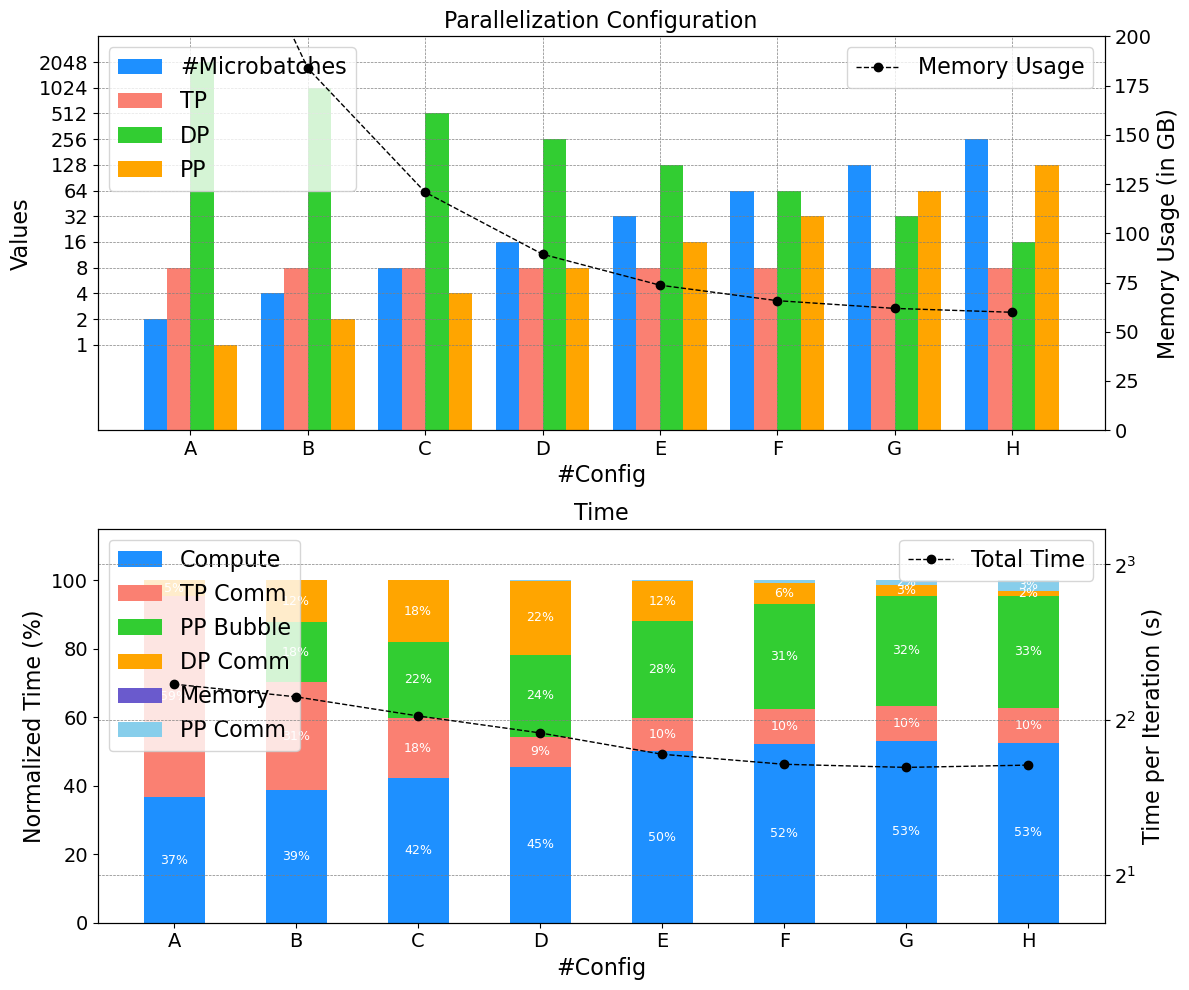

In [2]:
''' sweep over some parallel configs to reason about the configs.
    make sure the parallel configs are feasible (example, tp should
    divide #heads, pp should divide depth of the model, etc.'''

''' THIS CELL FOCUSES ON 1D TP '''

''' choose the transformer architecture hyperparameters  '''
parallel_strat = '1d' # FIXED
model_str = 'gpt3_1T'  # what model? choose from models.py (gpt3_1T, vit_era5) 
model = models.models[model_str]
# set model hyperparams
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print('model is {}'.format(model))

'''set some dataset size hyperparameters 
   if LLMs, it's number of tokens, else
   it's number of samples in ERA5.     '''

if model_str == 'gpt3_1T':
    total_tokens = 1 * 10**12
else:
    total_tokens = 300 * 10**9
    
num_samples = total_tokens / l
if 'vit_era5' in model_str:
    num_ep = 80
    num_samples = 350000 * num_ep
print('training on {} samples'.format(num_samples))
global_batch_size = 4096


'''choose a system'''
with open('../systems/config-B200.json', 'r') as file:
    system = json.load(file)
nvs = 8                # what nvs size?
system['nvlink_size'] = nvs
sys_str = 'B200-NVS{}'.format(nvs)

total_gpus = 16384     # how many GPUs to train?
N = 8                  # how many configs?

n_values = np.arange(0,N)
m_values =  [1] * N    # microbatch size (fix to 1 or change)

# make sure that PP cannot be greater than depth of your model
# make sure that TP cannot be greater than embed dim or number of heads
# for GPT3-1T, for example, with 160 heads, TP could at most be 32 to evenly divide the heads
# make sure that DP cannot be greater than global batch size

# keep TP fixed and sweep PP, DP
tp_values = np.array([8] * N) # choose TP = 8
pp_values = 2**np.arange(0, N) # sweep PP values
# set dp based on total gpus
dp_values = (total_gpus / (pp_values * tp_values)).astype(int)

# keep PP fixed and sweep TP, DP
# tp_values = 2**np.arange(0, N)
# pp_values = np.array([64] * N) # choose PP = 64
# # set dp based on total gpus
# dp_values = (total_gpus / (pp_values * tp_values)).astype(int)

# keep DP fixed and sweep TP, PP
# tp_values = 4 * 2**np.arange(0,N)
# dp_values = np.array([32] * N) # choose DP = 32
# pp_values = (total_gpus / (dp_values * tp_values)).astype(int)

print('TP values swept =  ', tp_values)
print('DP values swept =  ', dp_values)
print('PP values swept =  ', pp_values)
print('Total GPUs used =  ', dp_values * pp_values * tp_values)

time_part1 = []
time_part2 = []
time_part3 = []
time_part4 = []
time_part5 = []
time_part6 = []
nm_values = []
mem_values = []
for mbs,tp,pp,dp in zip(m_values,tp_values,pp_values,dp_values):
    best_time = np.inf
    best_mem = -np.inf
    stats = None
    for nv1, nv2, nv3 in nv_candidates_1d(tp, dp, pp, nvs):
        nm = (global_batch_size / dp) / mbs
        m1 = tp
        t1 = nv1
        t_dp = nv2
        t_pp = nv3
        df_mlp = mlp_1d(mbs, l, e, f, parallelism={'m': m1}, topology={'t': t1}, system=system)
        df_sa = sa_1d(mbs, l, e, h, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True, system=system)
        df_dp = dataparallel(modules=[df_mlp, df_sa], depth=(depth//pp), dp=dp, t_dp=t_dp, overlap=True, system=system)

        # pp comms
        # only communicate the last layer activations = first layer's (ln1) input buffer
        p2p_comm_vol = float(df_mlp.loc[df_mlp['name'] == 'ln1']['activation_buffer'])
        df_pp = pipelineparallel(modules=[df_mlp, df_sa], number_micro_batches=nm, comm_vol=p2p_comm_vol, pp=pp, t_pp=t_pp, overlap=False, system=system)

        # total time
        (t, mem), stats_running = totals(df_mlp, df_sa, df_dp, df_pp, depth, pp=pp, dp=dp, number_micro_batches=nm)
        stats_running['nv_tp'] = t1
        stats_running['nv_dp'] = t_dp
        stats_running['nv_pp'] = t_pp
        if t < best_time:
            stats = stats_running
            best_time = t
            best_mem = mem
    mem_values.append(best_mem)
            
    print('-------------------------')
    print('Config: tp = {}, dp = {}, pp = {}'.format(tp, dp, pp))
    print('TP in NVLINK: ', stats['nv_tp'])
    print('DP in NVLINK: ', stats['nv_dp'])
    print('PP in NVLINK: ', stats['nv_pp'])
    
    time_part1.append(stats['t_comp'])
    time_part2.append(stats['t_tp_comm'])
    time_part3.append(stats['t_bubble'])
    time_part4.append(stats['t_dp_comm'])
    time_part5.append(stats['t_mem'])
    time_part6.append(stats['t_pp_comm'])
    nm_values.append(nm)

    
m_values = nm_values # swap to #microbatches
time_part1 = np.array(time_part1)
time_part2 = np.array(time_part2)
time_part3 = np.array(time_part3)
time_part4 = np.array(time_part4)
time_part5 = np.array(time_part5)
time_part6 = np.array(time_part6)
time_total = time_part1 + time_part2 + time_part3 + time_part4 + time_part5 + time_part6
# normalize the time parts
time_parts = np.array([time_part1, time_part2, time_part3, time_part4, time_part5, time_part6])
time_parts_normalized = time_parts / time_total[:, np.newaxis].T * 100

plot = plot_configs(n_values, time_total, time_parts_normalized, 
                 mem_values, m_values, tp_values, dp_values, pp_values, use_log_scale=False)
# plot.savefig('../outputs/rationale_{}_{}_{}.pdf'.format(parallel_strat, model_str, sys_str), dpi=400)

model is {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128, 'f': 102400}
training on 488281250.0 samples
TP1 values swept =   [16, 8, 4, 2, 1, 8, 4, 2, 1]
TP2 values swept =   [1, 2, 4, 8, 16, 1, 2, 4, 8]
DP values swept =   [1024 1024 1024 1024 1024   16   16   16   16]
PP values swept =   [1, 1, 1, 1, 1, 128, 128, 128, 128]
Total GPUs used =   [16384 16384 16384 16384 16384 16384 16384 16384 16384]
-------------------------
Config: tp1 = 16, tp2 = 1, dp = 1024, pp = 1
TP1 in NVLINK:  8
TP2 in NVLINK:  1
DP in NVLINK:  1
PP in NVLINK:  1
-------------------------
Config: tp1 = 8, tp2 = 2, dp = 1024, pp = 1
TP1 in NVLINK:  4
TP2 in NVLINK:  2
DP in NVLINK:  1
PP in NVLINK:  1
-------------------------
Config: tp1 = 4, tp2 = 4, dp = 1024, pp = 1
TP1 in NVLINK:  2
TP2 in NVLINK:  4
DP in NVLINK:  1
PP in NVLINK:  1
-------------------------
Config: tp1 = 2, tp2 = 8, dp = 1024, pp = 1
TP1 in NVLINK:  1
TP2 in NVLINK:  8
DP in NVLINK:  1
PP in NVLINK:  1
-------------------------
Config: tp1 

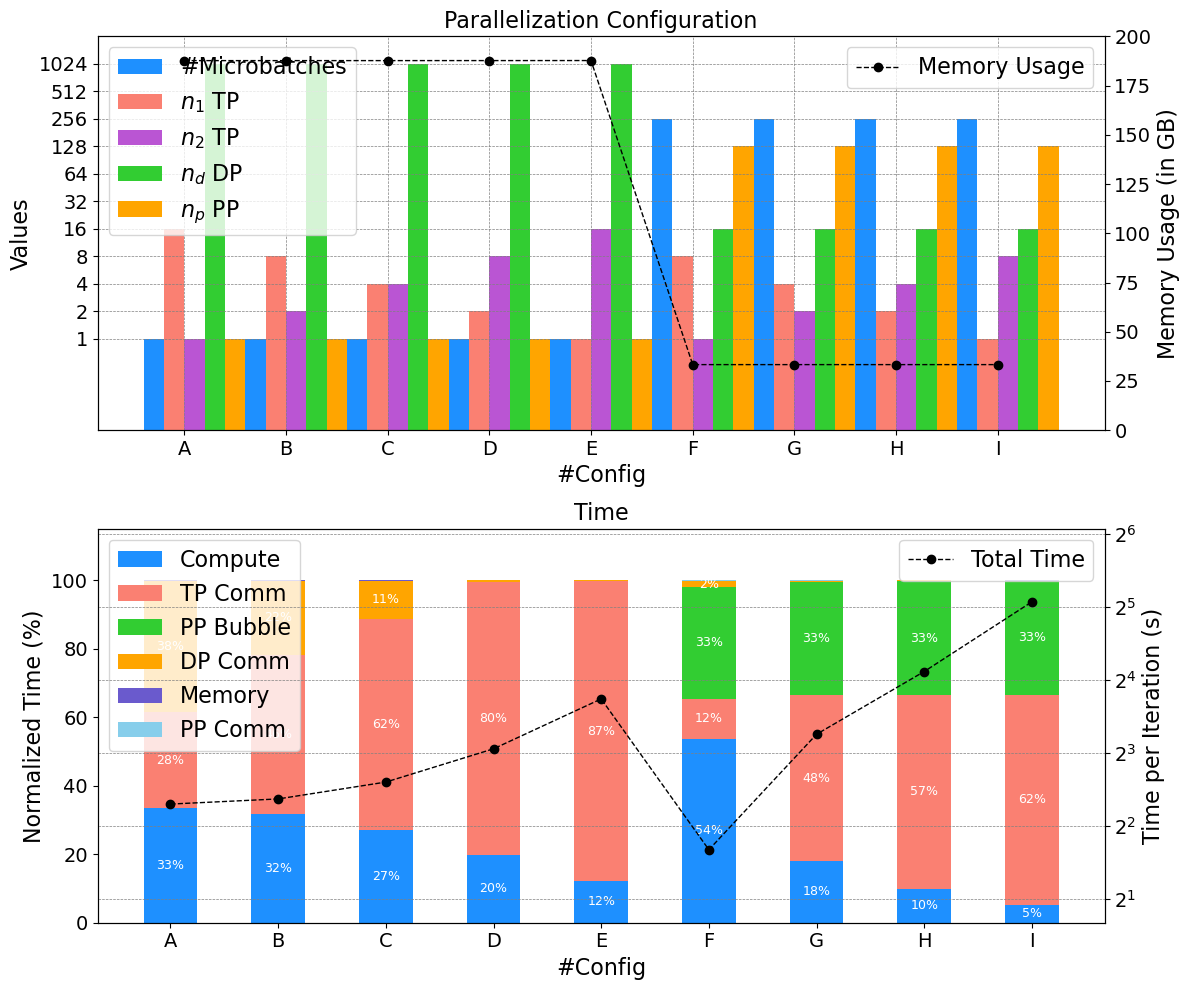

In [3]:
''' sweep over some parallel configs to reason about the configs.
    make sure the parallel configs are feasible (example, tp should
    divide #heads, pp should divide depth of the model, etc.'''

''' THIS CELL FOCUSES ON 2D VERSIONS OF TP (SUMMA)'''

''' choose the transformer architecture hyperparameters  '''
parallel_strat = '2d' # FIXED
model_str = 'gpt3_1T'  # what model? choose from models.py (gpt3_1T, vit_era5) 
model = models.models[model_str]
# set model hyperparams
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print('model is {}'.format(model))

'''set some dataset size hyperparameters 
   if LLMs, it's number of tokens, else
   it's number of samples in ERA5.     '''

if model_str == 'gpt3_1T':
    total_tokens = 1 * 10**12
else:
    total_tokens = 300 * 10**9
    
num_samples = total_tokens / l
if 'vit_era5' in model_str:
    num_ep = 80
    num_samples = 350000 * num_ep
print('training on {} samples'.format(num_samples))
global_batch_size = 4096


'''choose a system'''
with open('../systems/config-B200.json', 'r') as file:
    system = json.load(file)
nvs = 8                # what nvs size?
system['nvlink_size'] = nvs
system['summa_nb'] = 8 # set SUMMA nb dim
sys_str = 'B200-NVS{}'.format(nvs)

total_gpus = 16384     # how many GPUs to train?
N = 9                  # how many configs?

n_values = np.arange(0,N)

# make sure that PP cannot be greater than depth of your model
# make sure that TP cannot be greater than embed dim or number of heads
# for GPT3-1T, for example, with 160 heads, TP could at most be 32 to evenly divide the heads
# make sure that DP cannot be greater than global batch size

tp1_values   = [16,8,4,2,1,8,4,2,1]
tp2_values   = [1,2,4,8,16,1,2,4,8]
tp_values    = np.array(tp1_values) * np.array(tp2_values)
pp_values    = [1,1,1,1,1,128,128,128,128]
dp_values    = (total_gpus / (pp_values * tp_values)).astype(int)
m_values     = global_batch_size//(dp_values)
m_values[5:] = [1,1,1,1]

print('TP1 values swept =  ', tp1_values)
print('TP2 values swept =  ', tp2_values)
print('DP values swept =  ', dp_values)
print('PP values swept =  ', pp_values)
print('Total GPUs used =  ', dp_values * pp_values * tp1_values * tp2_values)

time_part1 = []
time_part2 = []
time_part3 = []
time_part4 = []
time_part5 = []
time_part6 = []
nm_values = []
mem_values = []
for mbs,tp1,tp2,pp,dp in zip(m_values,tp1_values,tp2_values,pp_values,dp_values):
    best_time = np.inf
    best_mem = -np.inf
    stats = None
    for nv1, nv2, nv3, nv4 in nv_candidates_2d(tp1, tp2, dp, pp, nvs):
        nm = (global_batch_size // dp) // mbs
        m1 = tp1
        m2 = tp2

        tp = tp1 * tp2

        # how many gpus in nvdomain
        t1 = nv1
        t2 = nv2
        t_dp = nv3
        t_pp = nv4

        df_mlp =  mlp_2d(mbs, l, e, f, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2}, system=system)
        df_sa = sa_2d_seqp(mbs, l, e, h, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2}, flash_attention=True, system=system)
        df_dp = dataparallel(modules=[df_mlp, df_sa], depth=(depth//pp), dp=dp, t_dp=t_dp, overlap=True, system=system)

        # pp comms
        # only communicate the last layer activations = first layer's (ln1) input buffer
        p2p_comm_vol = float(df_mlp.loc[df_mlp['name'] == 'ln1']['activation_buffer'])
        df_pp = pipelineparallel(modules=[df_mlp, df_sa], number_micro_batches=nm, comm_vol=p2p_comm_vol, pp=pp, t_pp=t_pp, overlap=False, system=system)

        # total time
        (t, mem), stats_running = totals(df_mlp, df_sa, df_dp, df_pp, depth, pp=pp, dp=dp, number_micro_batches=nm)
        stats_running['nv_tp1'] = t1
        stats_running['nv_tp2'] = t2
        stats_running['nv_dp'] = t_dp
        stats_running['nv_pp'] = t_pp
        if t < best_time:
            stats = stats_running
            best_time = t
            best_mem = mem
    mem_values.append(best_mem)
    # print('###')
            
    print('-------------------------')
    print('Config: tp1 = {}, tp2 = {}, dp = {}, pp = {}'.format(tp1, tp2, dp, pp))
    print('TP1 in NVLINK: ', stats['nv_tp1'])
    print('TP2 in NVLINK: ', stats['nv_tp2'])
    print('DP in NVLINK: ', stats['nv_dp'])
    print('PP in NVLINK: ', stats['nv_pp'])
 
    time_part1.append(stats['t_comp'])
    time_part2.append(stats['t_tp_comm'])
    time_part3.append(stats['t_bubble'])
    time_part4.append(stats['t_dp_comm'])
    time_part5.append(stats['t_mem'])
    time_part6.append(stats['t_pp_comm'])
    nm_values.append(nm)

    
m_values = nm_values # swap to #microbatches
time_part1 = np.array(time_part1)
time_part2 = np.array(time_part2)
time_part3 = np.array(time_part3)
time_part4 = np.array(time_part4)
time_part5 = np.array(time_part5)
time_part6 = np.array(time_part6)
time_total = time_part1 + time_part2 + time_part3 + time_part4 + time_part5 + time_part6
# normalize the time parts
time_parts = np.array([time_part1, time_part2, time_part3, time_part4, time_part5, time_part6])
time_parts_normalized = time_parts / time_total[:, np.newaxis].T * 100

plot = plot_configs(n_values, time_total, time_parts_normalized, 
                 mem_values, m_values, tp_values, dp_values, pp_values, tp1_values, tp2_values, use_log_scale=False)
# plot.savefig('../outputs/rationale_{}_{}_{}.pdf'.format(parallel_strat, model_str, sys_str), dpi=400)

model is {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128, 'f': 102400}
training on 488281250.0 samples
TP1 values swept =   [16, 8, 4, 2, 1, 8, 4, 2, 1]
TP2 values swept =   [1, 2, 4, 8, 16, 1, 2, 4, 8]
DP values swept =   [1024 1024 1024 1024 1024   32   32   32   32]
PP values swept =   [1, 1, 1, 1, 1, 64, 64, 64, 64]
Total GPUs used =   [16384 16384 16384 16384 16384 16384 16384 16384 16384]
-------------------------
Config: tp1 = 16, tp2 = 1, dp = 1024, pp = 1
TP1 in NVLINK:  4
TP2 in NVLINK:  1
DP in NVLINK:  2
PP in NVLINK:  1
-------------------------
Config: tp1 = 8, tp2 = 2, dp = 1024, pp = 1
TP1 in NVLINK:  2
TP2 in NVLINK:  2
DP in NVLINK:  2
PP in NVLINK:  1
-------------------------
Config: tp1 = 4, tp2 = 4, dp = 1024, pp = 1
TP1 in NVLINK:  1
TP2 in NVLINK:  4
DP in NVLINK:  2
PP in NVLINK:  1
-------------------------
Config: tp1 = 2, tp2 = 8, dp = 1024, pp = 1
TP1 in NVLINK:  1
TP2 in NVLINK:  8
DP in NVLINK:  1
PP in NVLINK:  1
-------------------------
Config: tp1 = 1,

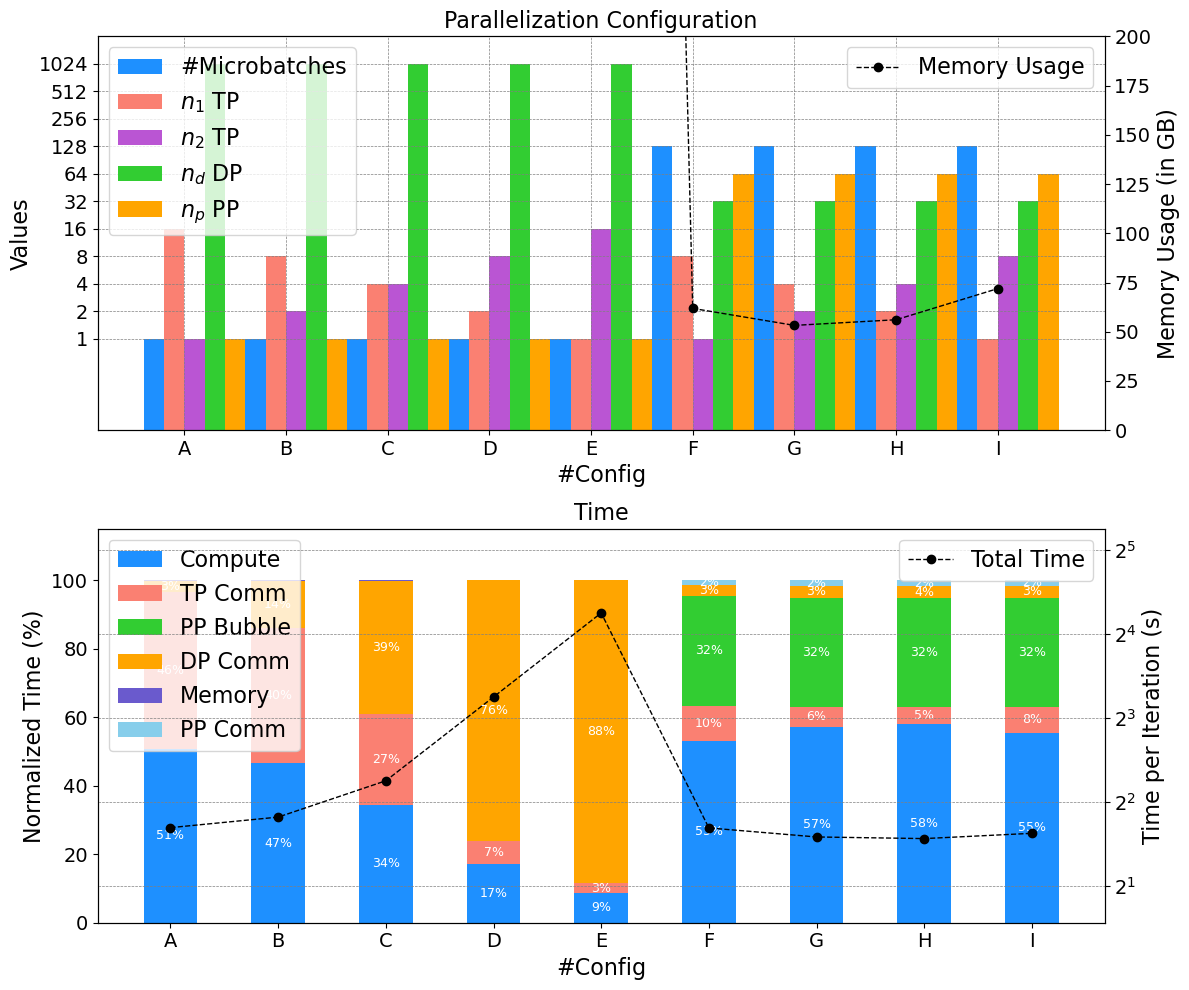

In [4]:
''' sweep over some parallel configs to reason about the configs.
    make sure the parallel configs are feasible (example, tp should
    divide #heads, pp should divide depth of the model, etc.'''

''' THIS CELL FOCUSES ON 2D VERSIONS OF TP (CONTEXT PARALLEL)'''

''' choose the transformer architecture hyperparameters  '''
parallel_strat = '2d-seqp' # FIXED
model_str = 'gpt3_1T'  # what model? choose from models.py (gpt3_1T, vit_era5) 
model = models.models[model_str]
# set model hyperparams
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print('model is {}'.format(model))

'''set some dataset size hyperparameters 
   if LLMs, it's number of tokens, else
   it's number of samples in ERA5.     '''

if model_str == 'gpt3_1T':
    total_tokens = 1 * 10**12
else:
    total_tokens = 300 * 10**9
    
num_samples = total_tokens / l
if 'vit_era5' in model_str:
    num_ep = 80
    num_samples = 350000 * num_ep
print('training on {} samples'.format(num_samples))
global_batch_size = 4096


'''choose a system'''
with open('../systems/config-B200.json', 'r') as file:
    system = json.load(file)
nvs = 8                # what nvs size?
system['nvlink_size'] = nvs
sys_str = 'B200-NVS{}'.format(nvs)

total_gpus = 16384     # how many GPUs to train?
N = 9                  # how many configs?

n_values = np.arange(0,N)

# make sure that PP cannot be greater than depth of your model
# make sure that TP cannot be greater than embed dim or number of heads
# for GPT3-1T, for example, with 160 heads, TP could at most be 32 to evenly divide the heads
# make sure that DP cannot be greater than global batch size

tp1_values   = [16,8,4,2,1,8,4,2,1]
tp2_values   = [1,2,4,8,16,1,2,4,8]
tp_values    = np.array(tp1_values) * np.array(tp2_values)
pp_values    = [1]*5 + [64]*4
dp_values    = (total_gpus / (pp_values * tp_values)).astype(int)
m_values     = global_batch_size//(dp_values)
m_values[5:] = [1,1,1,1]

print('TP1 values swept =  ', tp1_values)
print('TP2 values swept =  ', tp2_values)
print('DP values swept =  ', dp_values)
print('PP values swept =  ', pp_values)
print('Total GPUs used =  ', dp_values * pp_values * tp1_values * tp2_values)

time_part1 = []
time_part2 = []
time_part3 = []
time_part4 = []
time_part5 = []
time_part6 = []
nm_values = []
mem_values = []
for mbs,tp1,tp2,pp,dp in zip(m_values,tp1_values,tp2_values,pp_values,dp_values):
    best_time = np.inf
    best_mem = -np.inf
    stats = None
    for nv1, nv2, nv3, nv4 in nv_candidates_2d(tp1, tp2, dp, pp, nvs):
        nm = (global_batch_size // dp) // mbs
        m1 = tp1
        m2 = tp2

        tp = tp1 * tp2

        # how many gpus in nvdomain
        t1 = nv1
        t2 = nv2
        t_dp = nv3
        t_pp = nv4

        df_mlp =  mlp_seqp(mbs, l, e, f, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2}, system=system)
        df_sa = sa_seqp(mbs, l, e, h, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2}, flash_attention=True, system=system)
        df_dp = dataparallel(modules=[df_mlp, df_sa], depth=(depth//pp), dp=dp*tp2, t_dp=t_dp*t2, overlap=True, system=system)

        # pp comms
        # only communicate the last layer activations = first layer's (ln1) input buffer
        p2p_comm_vol = float(df_mlp.loc[df_mlp['name'] == 'ln1']['activation_buffer'])
        df_pp = pipelineparallel(modules=[df_mlp, df_sa], number_micro_batches=nm, comm_vol=p2p_comm_vol, pp=pp, t_pp=t_pp, overlap=False, system=system)

        # total time
        (t, mem), stats_running = totals(df_mlp, df_sa, df_dp, df_pp, depth, pp=pp, dp=dp, number_micro_batches=nm)
        stats_running['nv_tp1'] = t1
        stats_running['nv_tp2'] = t2
        stats_running['nv_dp'] = t_dp
        stats_running['nv_pp'] = t_pp
        if t < best_time:
            stats = stats_running
            best_time = t
            best_mem = mem
    mem_values.append(best_mem)
    # print('###')
            
    print('-------------------------')
    print('Config: tp1 = {}, tp2 = {}, dp = {}, pp = {}'.format(tp1, tp2, dp, pp))
    print('TP1 in NVLINK: ', stats['nv_tp1'])
    print('TP2 in NVLINK: ', stats['nv_tp2'])
    print('DP in NVLINK: ', stats['nv_dp'])
    print('PP in NVLINK: ', stats['nv_pp'])
 
    time_part1.append(stats['t_comp'])
    time_part2.append(stats['t_tp_comm'])
    time_part3.append(stats['t_bubble'])
    time_part4.append(stats['t_dp_comm'])
    time_part5.append(stats['t_mem'])
    time_part6.append(stats['t_pp_comm'])
    nm_values.append(nm)

    
m_values = nm_values # swap to #microbatches
time_part1 = np.array(time_part1)
time_part2 = np.array(time_part2)
time_part3 = np.array(time_part3)
time_part4 = np.array(time_part4)
time_part5 = np.array(time_part5)
time_part6 = np.array(time_part6)
time_total = time_part1 + time_part2 + time_part3 + time_part4 + time_part5 + time_part6
# normalize the time parts
time_parts = np.array([time_part1, time_part2, time_part3, time_part4, time_part5, time_part6])
time_parts_normalized = time_parts / time_total[:, np.newaxis].T * 100

plot = plot_configs(n_values, time_total, time_parts_normalized, 
                 mem_values, m_values, tp_values, dp_values, pp_values, tp1_values, tp2_values, use_log_scale=False)
# plot.savefig('../outputs/rationale_{}_{}_{}.pdf'.format(parallel_strat, model_str, sys_str), dpi=400)